In [1]:
import e2cnn
from e2cnn import gspaces
from e2cnn import nn as e2nn
import torch
import torch.multiprocessing
from torch import nn
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from src.nn_training import Group
from tqdm.notebook import tqdm
import seaborn as sns
sns.set_style()

/state/partition1/llgrid/pkg/anaconda/anaconda3-2021b/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [2]:
transform_comp = transforms.Compose([transforms.ToTensor(),
                                     transforms.Resize((28, 28)),
                                     transforms.Normalize((0.1307,), (0.3081,))])
mnist_data = datasets.MNIST('./data', transform=transform_comp)

batch_size = 250
data_loader = torch.utils.data.DataLoader(mnist_data,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=20)

In [3]:
for i, batch in enumerate(data_loader):
    x, y = batch
    break
x = x[0:1, ...]

In [30]:
def get_schatten_norm_sum(fcoeffs, irrep_sizes, l):
    """
    Given the Fourier coefficients of the linearization of our network,
    this f-n computes the expression for which we want to reach a scaling
    of its stationary point in our main theorems (Thm 4.2 and Thm 4.4).
    """
    
    # all we're doing here is getting the 2/l norm of the singular values
    # of the block diagonal matrix that has each of the irreps of dim n
    # repeated n times along its diagonal
    
    # our code could also be written more cleanly/concisely as
    # block_diag_matrix_irrs = torch.block_diag(*[torch.block_diag(*([flat_irrep.reshape(size, size)] * size)) 
    #                                                              for size, flat_irrep in zip(irrep_sizes, fcoeffs)])
    # sigmas = torch.linalg.svdvals(block_diag_matrix_irrs)
    # return torch.linalg.vector_norm(sigmas, ord=(2./3.))
    # but that'd be a bit slower because of the SVD on a larger (though sparse) matrix
    
    sum_of_schatten_norms = 0.
    flat_irreps_list = torch.split(fcoeffs, [s ** 2 for s in irrep_sizes])

    for flat_irrep, irrep_size in zip(flat_irreps_list, irrep_sizes):
        irrep = flat_irrep.reshape(irrep_size, irrep_size)
        try:
            sigmas = torch.linalg.svdvals(irrep)
        except:
            return None
        sum_of_schatten_norms += irrep_size * torch.linalg.vector_norm(sigmas, ord=(2. / l)) ** (2. / l)
    return sum_of_schatten_norms ** (l / 2.)

def eval_schatten_norm(net, inps):
    group = Group('MNIST')
    fourier_m = group.f_mat
    net.eval()
    sch_norms = []
    for i in range(1):
        interm, out = net(inps[i:i + 1])
        out.backward()
        if net.is_fc:
            linearization = interm.grad[0].reshape(-1, 1) - 1.
        else:
            linearization = interm.grad[0].permute([1, 2, 0])
            # re-order to match GAP order
            linearization = linearization[:, :, [0, 2, 1, 3, 4, 6, 5, 7]].reshape(-1, 1) - 1.
        linearization = linearization / torch.linalg.norm(linearization)
        linearization = torch.complex(linearization, torch.zeros_like(linearization))
        fspace_linearization = torch.conj(fourier_m).T @ linearization
        sch_norm = get_schatten_norm_sum(fspace_linearization, group.irrep_sizes, 3)
        sch_norms.append(sch_norm)
    net.train()
    return torch.stack(sch_norms).mean()

def exp_loss(y_pred, y):
    """
    Exponential loss for classification.
    """
    return torch.mean(torch.exp(-y_pred * y))

def postprocess(batch):
    x, y = batch
    # classify 0 vs 5, ignore other digits
    x = x[(y == 0) + (y == 5)]
    y = y[(y == 0) + (y == 5)]
    y[y == 5] = -1
    y[y == 0] = 1
    y = y.reshape(-1, 1)
    reduced_bs = len(y)
    return x, y

In [31]:
class Gcnn(torch.nn.Module):
    def __init__(self):
        super(Gcnn, self).__init__()
        self.r2_act = gspaces.FlipRot2dOnR2(N=4)

        self.feat_type_in  = e2nn.FieldType(self.r2_act, [self.r2_act.trivial_repr])
        self.feat_type_out = e2nn.FieldType(self.r2_act, [self.r2_act.regular_repr])
        self.conv1 = e2nn.R2Conv(self.feat_type_in, self.feat_type_out,
                                 kernel_size=25, padding=12,
                                 padding_mode='circular', bias=False)
        self.conv2 = e2nn.R2Conv(self.feat_type_out, self.feat_type_out,
                                 kernel_size=15, padding=0,
                                 padding_mode='circular', bias=False)
        self.conv3 = e2nn.R2Conv(self.feat_type_out, self.feat_type_out,
                                 kernel_size=13, padding=0,
                                 padding_mode='circular', bias=False)
        self.relu = e2nn.ELU(self.feat_type_out)
        self.pooling = e2nn.GroupPooling(self.feat_type_out)
        self.batchnorm = e2nn.InnerBatchNorm(self.feat_type_out)

        self.nonlinear = True
        self.is_g = True
        self.is_fc = False
        self.l = 3

    def forward(self, x):
        bs = x.size(0)
        x = e2nn.GeometricTensor(x, self.feat_type_in)
        interm = self.conv1(x)
        interm.tensor.retain_grad()
#         x = self.batchnorm(interm)
#         x = self.relu(x)
        x = self.relu(interm)
        x = self.conv2(x)
#         x = self.batchnorm(x)
        x = self.relu(x)
        x = self.conv3(x)
#         x = self.batchnorm(x)
#         x = self.pooling(x)

        return interm.tensor, torch.mean(x.tensor.reshape(bs, -1), axis=1, keepdim=True)

In [32]:
class Cnn(torch.nn.Module):
    def __init__(self):
        super(Cnn, self).__init__()
        self.r2_act = gspaces.TrivialOnR2()

        self.feat_type_in  = e2nn.FieldType(self.r2_act, [self.r2_act.regular_repr])
        self.feat_type_out = e2nn.FieldType(self.r2_act, 8 * [self.r2_act.regular_repr])
        self.conv1 = e2nn.R2Conv(self.feat_type_in, self.feat_type_out,
                                 kernel_size=25, padding=12, 
                                 padding_mode='circular', bias=False)
        self.conv2 = e2nn.R2Conv(self.feat_type_out, self.feat_type_out,
                                 kernel_size=15, bias=False)
        self.conv3 = e2nn.R2Conv(self.feat_type_out, self.feat_type_out,
                                 kernel_size=13, bias=False)
        self.relu = e2nn.ELU(self.feat_type_out)
        self.pooling = e2nn.GroupPooling(self.feat_type_out, )

        self.nonlinear = True
        self.is_g = False
        self.is_fc = False
        self.l = 3


    def forward(self, x):
        bs = x.size(0)
        x = e2nn.GeometricTensor(x, self.feat_type_in)
        interm = self.conv1(x)
        interm.tensor.retain_grad()
        x = self.relu(interm)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)

        return interm.tensor, torch.mean(x.tensor.reshape(bs, -1), axis=1, keepdim=True)

In [37]:
class FCnet(torch.nn.Module):
    def __init__(self):
        super(FCnet, self).__init__()
        self.lin1 = nn.Linear(784, 6272)
        self.lin2 = nn.Linear(6272, 128)
        self.lin3 = nn.Linear(128, 1)
        self.relu = nn.ReLU()

        self.nonlinear = True
        self.is_g = False
        self.is_fc = True
        self.l = 3
        
    def forward(self, x):
        bs = x.size(0)
        interm = self.lin1(x.reshape(bs, -1))
        interm.retain_grad()
        x = self.relu(interm)
        x = self.lin2(x)
        x = self.relu(x)
        x = self.lin3(x)
        
        return interm, torch.mean(x.reshape(bs, -1), axis=1, keepdim=True)

# Training

In [34]:
epochs = 300
num_batches = 1
init_lr= 1e-3
N = 15

In [35]:
dataset = [postprocess(batch) for batch in data_loader]

## G-CNN

In [76]:
%%time
results_gcnn = []
for run_itr in range(N):
    net = Gcnn().train()
    optimizer = optim.SGD(net.parameters(), lr=init_lr)
    loss = torch.Tensor([1.])
    acc = torch.Tensor([0.])
    for epoch in range(epochs):
        net.train()
#         itr = tqdm(enumerate(dataset[0:num_batches]))
        itr = enumerate(dataset[0:num_batches])
        if epoch == 150:
            for g in optimizer.param_groups:
                g['lr'] /= 5.
        for i, batch in itr:
            x, y = batch
            if epoch % 5 == 0 and i == 0:
                sch_norm = eval_schatten_norm(net, x)
#                 print(f'Schatten norm at epoch {epoch} is {sch_norm:.1f}; acc: {acc.item()}')
                results_gcnn.append([run_itr, epoch, sch_norm.item(), loss.item()])

            optimizer.zero_grad()
            interm, preds = net(x)
#             loss = (torch.abs(torch.sigmoid(preds) - y)).mean()
            loss = exp_loss(preds, y)
            loss.backward()
            optimizer.step()

            acc = torch.sum(torch.sign(preds) == y) / len(y)
#             itr.set_description(f'loss: {loss.item():.4f}, acc: {acc.item():.3f}')

CPU times: user 17h 28min 21s, sys: 58min 56s, total: 18h 27min 18s
Wall time: 30min 18s


In [77]:
dfs_gcnn = pd.DataFrame(results_gcnn, columns=['N', 'epoch', 'schatten norm', 'loss'])

In [95]:
dfs_gcnn.to_csv('gcnn_e2.csv', index=False)

In [9]:
dfs_gcnn = pd.read_csv('gcnn_e2.csv')

## CNN

In [80]:
%%time
results_cnn = []
for run_itr in range(N):
    net = Cnn()
    optimizer = optim.SGD(net.parameters(), lr=init_lr)
    loss = torch.Tensor([1.])
    acc = torch.Tensor([0.])    
    for epoch in range(epochs):
#         itr = tqdm(enumerate(dataset[0:num_batches]))
        itr = enumerate(dataset[0:num_batches])
        if epoch == 150:
            for g in optimizer.param_groups:
                g['lr'] /= 5.
        for i, batch in itr:
            x, y = batch
            if epoch % 5 == 0 and i == 0:
                sch_norm = eval_schatten_norm(net, x)
#                 print(f'Schatten norm at epoch {epoch} is {sch_norm:.1f}; acc is {acc.item()}')
                results_cnn.append([run_itr, epoch, sch_norm.item(), loss.item()])

            optimizer.zero_grad()
            interm, preds = net(x)
            loss = exp_loss(preds, y)
            loss.backward()
            optimizer.step()
            acc = torch.sum(torch.sign(preds - 1.) == y) / len(y)
#             itr.set_description(f'loss: {loss.item():.4f}, acc: {acc.item():.3f}')

CPU times: user 16h 20min 17s, sys: 56min 15s, total: 17h 16min 33s
Wall time: 27min 45s


In [81]:
dfs_cnn = pd.DataFrame(results_cnn, columns=['N', 'epoch', 'schatten norm', 'loss'])

In [94]:
dfs_cnn.to_csv('cnn_e2.csv', index=False)

In [10]:
dfs_cnn = pd.read_csv('cnn_e2.csv')

# FC net

In [44]:
%%time
results_fcnet = []
for run_itr in tqdm(range(N)):
    net = FCnet()
    optimizer = optim.SGD(net.parameters(), lr=init_lr)
    loss = torch.Tensor([1.])
    acc = torch.Tensor([0.])    
    for epoch in tqdm(range(epochs)):
#         itr = tqdm(enumerate(dataset[0:num_batches]))
        itr = enumerate(dataset[0:num_batches])
        if epoch == 150:
            for g in optimizer.param_groups:
                g['lr'] /= 5.
        for i, batch in itr:
            x, y = batch
            if epoch % 5 == 0 and i == 0:
                sch_norm = eval_schatten_norm(net, x)
#                 print(f'Schatten norm at epoch {epoch} is {sch_norm:.1f}; acc is {acc.item()}')
                results_fcnet.append([run_itr, epoch, sch_norm.item(), loss.item()])

            optimizer.zero_grad()
            interm, preds = net(x)
            loss = exp_loss(preds, y)
            loss.backward()
            optimizer.step()
            acc = torch.sum(torch.sign(preds - 1.) == y) / len(y)
#             itr.set_description(f'loss: {loss.item():.4f}, acc: {acc.item():.3f}')

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

CPU times: user 5h 14min 16s, sys: 13min 28s, total: 5h 27min 44s
Wall time: 6min 54s


In [45]:
dfs_fcnet = pd.DataFrame(results_fcnet, columns=['N', 'epoch', 'schatten norm', 'loss'])

In [46]:
dfs_fcnet.to_csv('fcnet_e2.csv', index=False)

In [47]:
dfs_fcnet = pd.read_csv('fcnet_e2.csv')

# Plots

In [48]:
scaling=1.8

In [49]:
color_palette = sns.color_palette('colorblind', 3)

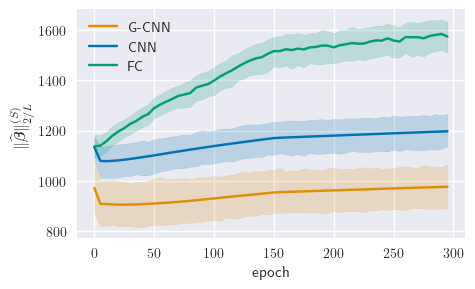

In [51]:
# sns.lineplot(dfs_gcnn["epoch"], dfs_gcnn["schatten_norm"], label='G-CNN')
plt.figure(figsize=(scaling * 2.695, scaling * 1.666))
sns.lineplot(data=dfs_gcnn, x="epoch", y="schatten norm", label='G-CNN',
             color=color_palette[1])
sns.lineplot(data=dfs_cnn, x="epoch", y="schatten norm", label='CNN',
             color=color_palette[0])
sns.lineplot(data=dfs_fcnet, x="epoch", y="schatten norm", label='FC',
             color=color_palette[2])
plt.ylabel(r'$\displaystyle\|\widehat{\boldsymbol{\beta}}\|^{(S)}_{2/L}$')
plt.legend()
plt.savefig('e2_fourier_norm.pdf')
plt.show()

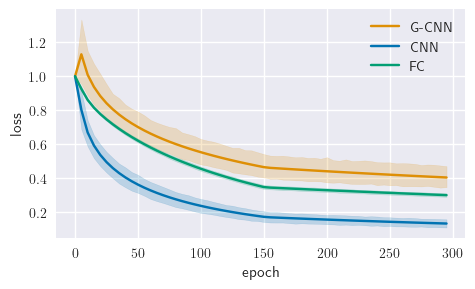

In [52]:
plt.figure(figsize=(scaling * 2.695, scaling * 1.666))
sns.lineplot(data=dfs_gcnn, x="epoch", y="loss", label='G-CNN',
             color=color_palette[1])
sns.lineplot(data=dfs_cnn, x="epoch", y="loss", label='CNN',
             color=color_palette[0])
sns.lineplot(data=dfs_fcnet, x="epoch", y="loss", label='FC',
             color=color_palette[2])
plt.legend();
plt.savefig('e2_loss.pdf')
plt.show()